## Lab 6

### Data Collection and Preprocessing

In [1]:
import yfinance as yf
data = yf.download("MSFT", start="2018-01-01",end="2023-12-31")
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,,
2018-01-02 00:00:00+00:00,79.792915,85.949997,86.309998,85.500000,86.129997,22483800
2018-01-03 00:00:00+00:00,80.164253,86.349998,86.510002,85.970001,86.059998,26061400
2018-01-04 00:00:00+00:00,80.869812,87.110001,87.660004,86.570000,86.589996,21912000
2018-01-05 00:00:00+00:00,81.872475,88.190002,88.410004,87.430000,87.660004,23407100
2018-01-08 00:00:00+00:00,81.956017,88.279999,88.580002,87.599998,88.199997,22113000


<Axes: xlabel='Ticker'>

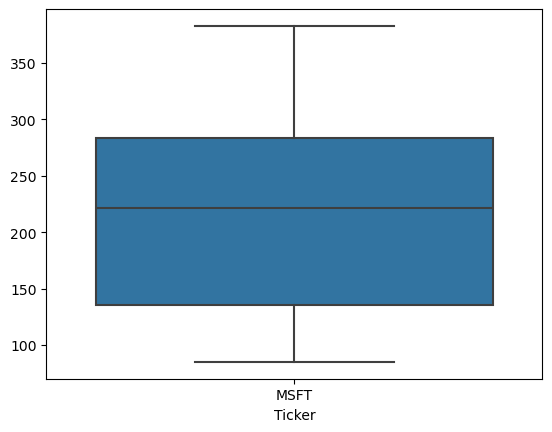

In [2]:
import seaborn as sns
sns.boxplot(data.Close)

### Exploratory Data Analysis (EDA)

<Axes: xlabel='Date'>

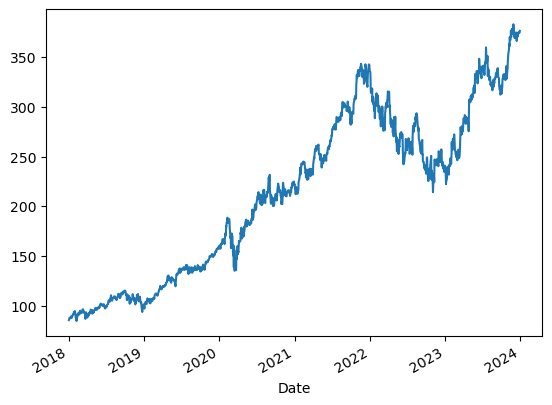

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose 
output=seasonal_decompose(data.Close, model='multiplicative', period=1).trend
output.plot() 

<Axes: xlabel='Date'>

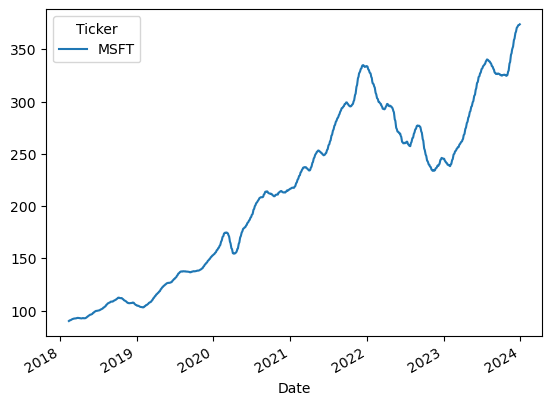

In [4]:
moving=data.Close.rolling(30)
moving.mean().plot()

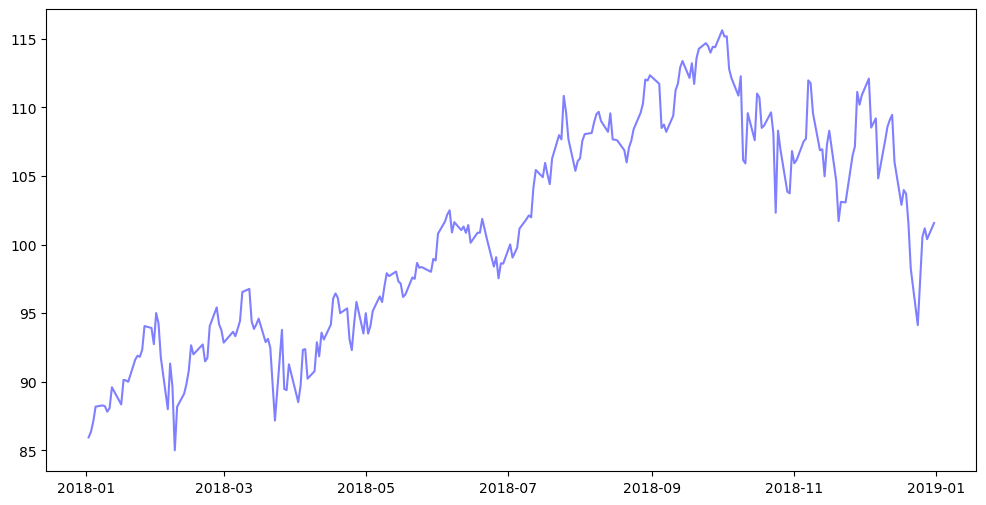

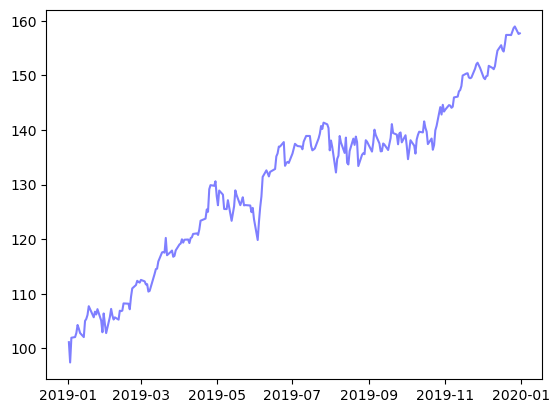

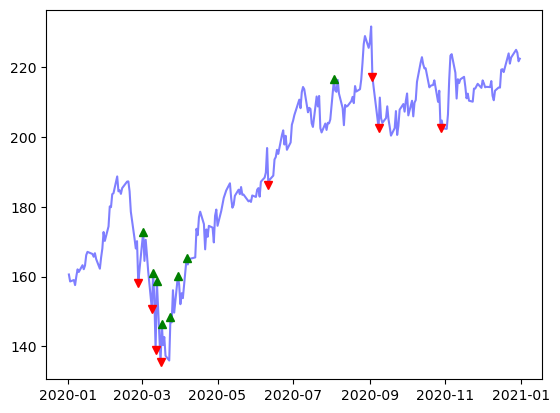

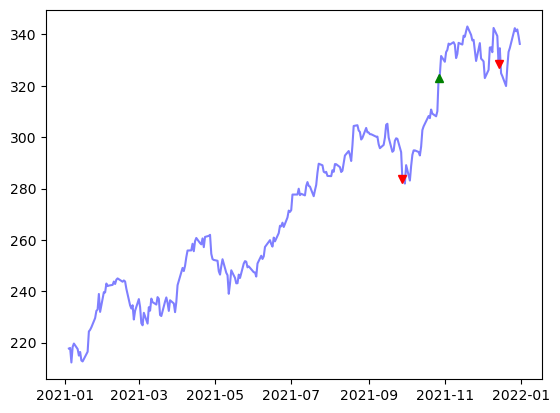

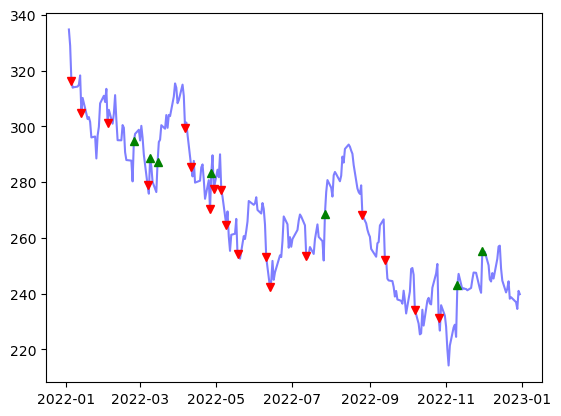

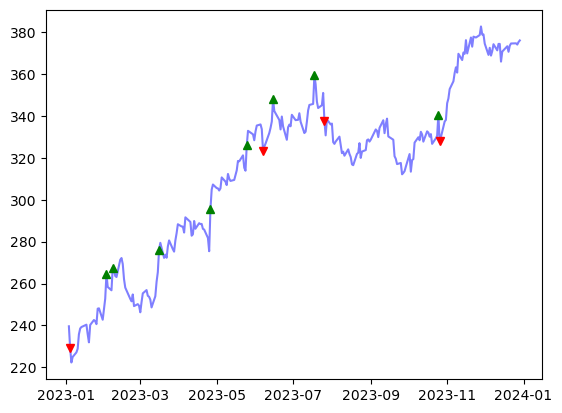

In [5]:
import matplotlib.pyplot as plt
import numpy as np
close=data['Close'].values 
data['Year']=data.index.year
def identify_peaks_and_dips(close):
    peak = []
    dip = []
    for i in range(len(close) - 1):
        if close[i + 1] - close[i] >= 10:
            peak.append(i+1)
        if close[i] - close[i + 1] >= 10:
            dip.append(i+1)
    return np.array(peak), np.array(dip)
    
years = data['Year'].unique()

plt.figure(figsize=(12, 6))
for year in years:
    yearly_data = data[data['Year'] == year]
    yearly_close = yearly_data['Close'].values
    peak, dip = identify_peaks_and_dips(yearly_close)
    
    plt.plot(yearly_data.index, yearly_close, label=f'Closing Price {year}', color='blue', alpha=0.5)
    if len(peak) > 0: 
        plt.plot(yearly_data.index[peak], yearly_close[peak], "^", label=f"Peaks {year}", color="green")
    if len(dip) > 0: 
        plt.plot(yearly_data.index[dip], yearly_close[dip], "v", label=f"Dips {year}", color="red")
    plt.show()

### Time Series Visualization

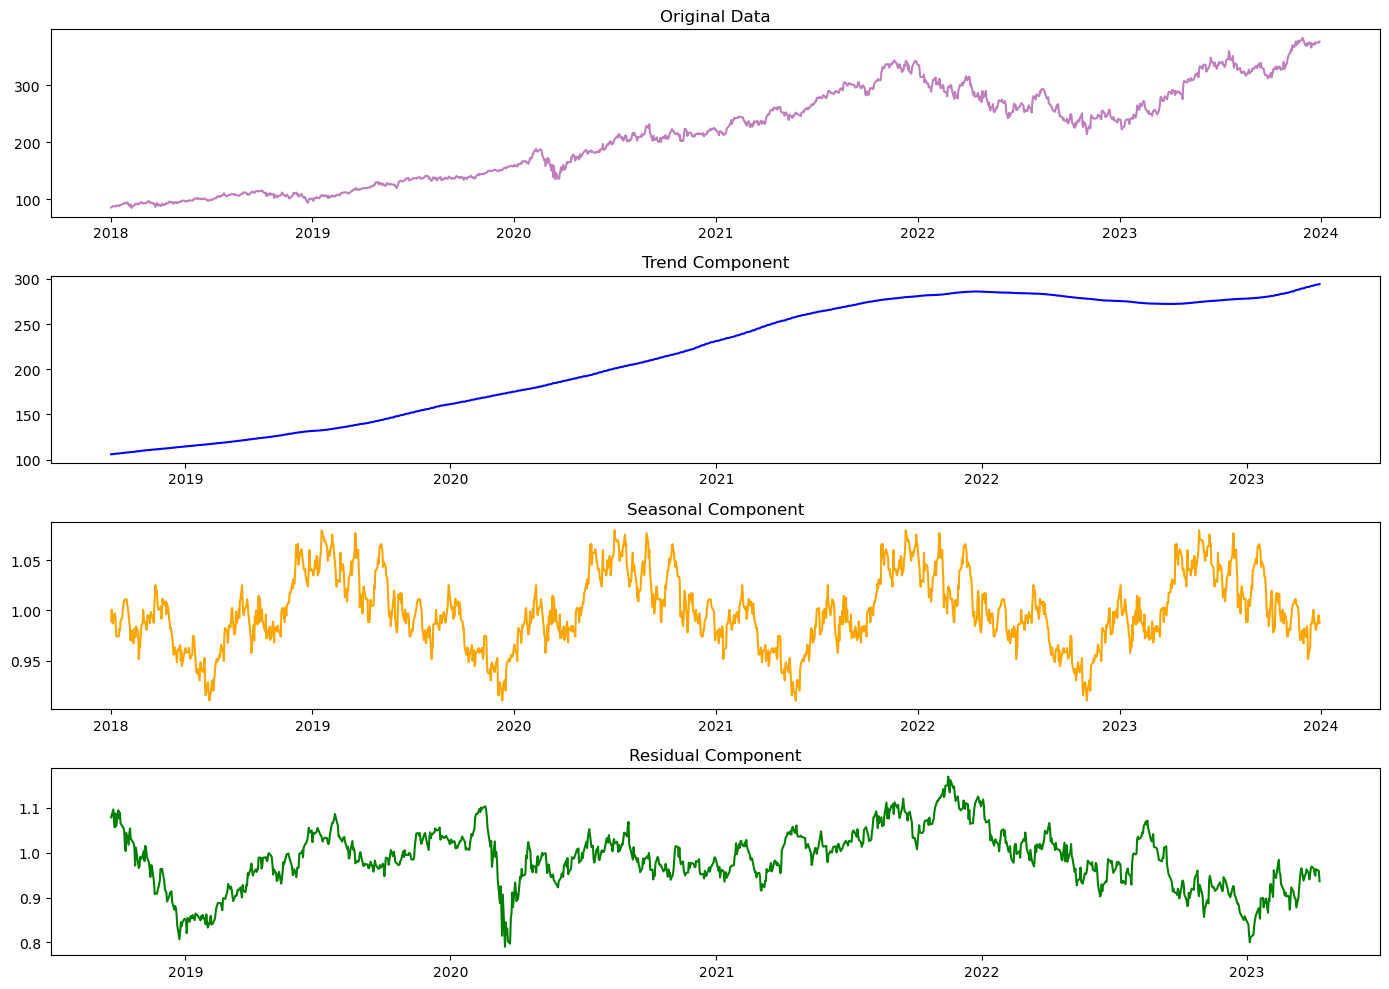

In [6]:
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=365)
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(data['Close'], label='Original Data', color='purple', alpha=0.5)
plt.title('Original Data')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend Component')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='green')
plt.title('Residual Component')
plt.tight_layout()
plt.show()

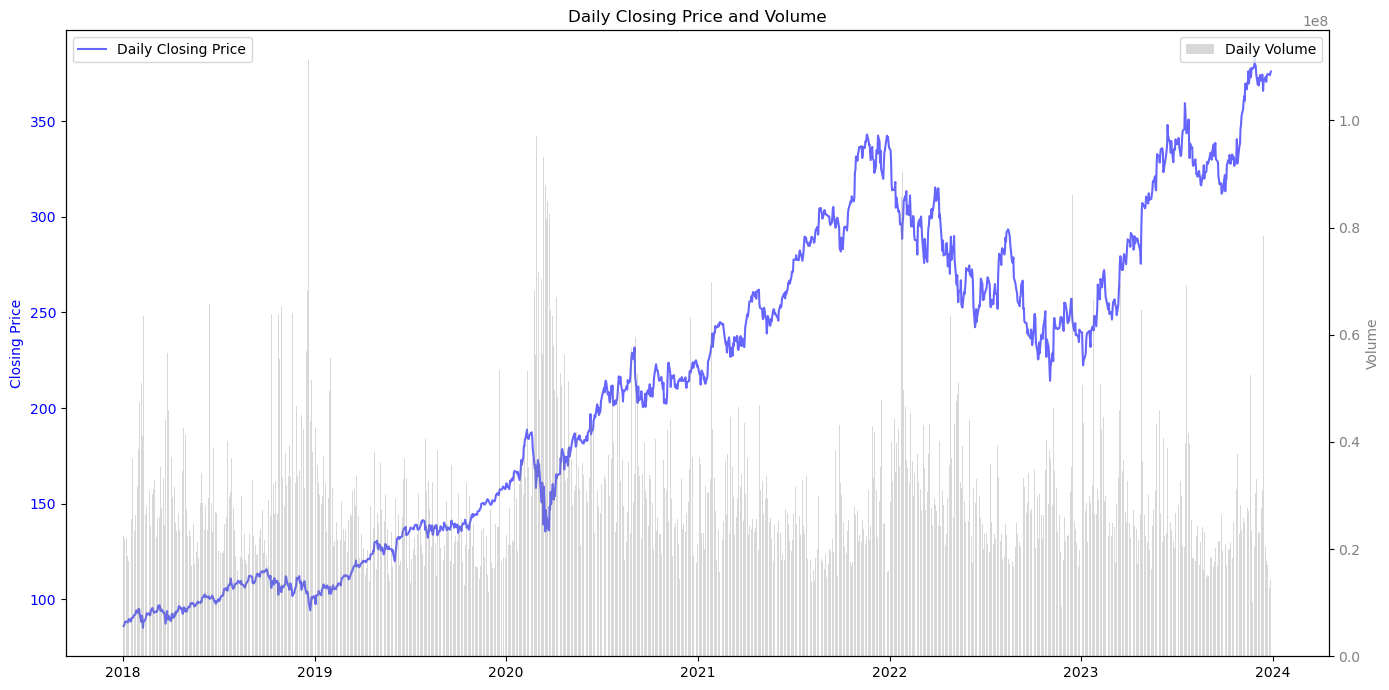

In [7]:
volume=data.Volume.values.flatten()
plt.figure(figsize=(14, 7))
ax1 = plt.gca()  # Get current axis
ax1.plot(data.index, data['Close'], color='blue', label='Daily Closing Price', alpha=0.6)
ax1.set_ylabel('Closing Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.bar(data.index, volume, color='gray', alpha=0.3, label='Daily Volume', width=1)  # Width is adjusted for clarity
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
plt.title('Daily Closing Price and Volume')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Volatility Analysis

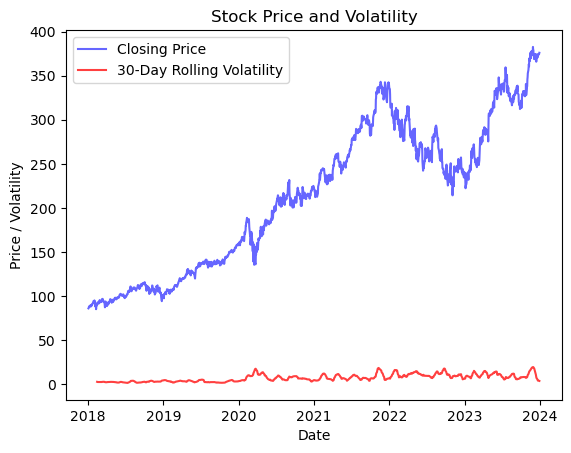

In [8]:
plt.plot(data.Close, color='blue', label='Closing Price', alpha=0.6)
plt.plot(data.Close.rolling(30).std(), color='red', label='30-Day Rolling Volatility', alpha=0.75)
plt.title('Stock Price and Volatility')
plt.xlabel('Date')
plt.ylabel('Price / Volatility')
plt.legend()
plt.show()

### Forecasting

In [9]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(data.Close)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -0.37265427322085226
p-value: 0.914565390711247
The time series is not stationary.


In [10]:
data['log'] = np.log(data['Close'])
result=adfuller(data.log)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -1.1186126201704807
p-value: 0.7075926227341267
The time series is not stationary.


In [11]:
data['difference']=data.log.diff()
data.difference=data.difference.fillna(0)
result=adfuller(data.difference)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -13.00135233493052
p-value: 2.683191104019869e-24
The time series is stationary.


In [12]:
from pmdarima.arima import auto_arima
model = auto_arima(data.difference, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6367.181, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6982.450, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7564.460, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6369.181, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7588.929, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7591.656, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7702.468, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7652.986, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7666.041, Time=0.64 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-7670.669, Time=0.93 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7700.397, Time=1.01 sec
 ARIMA(1,1,3)(0,0,0)[0]             :

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
model=ARIMA(data['difference'],order=(1, 1, 3))
fitted_model=model.fit()

In [14]:
test=yf.download("MSFT", start="2024-01-01",end="2024-01-30")
test.shape

[*********************100%***********************]  1 of 1 completed


(19, 6)

In [15]:
forecast=fitted_model.forecast(steps=19)

In [16]:
last_log_value=data['log'].iloc[-1] 
logforecast=[]
for diff in forecast:
    last_log_value+=diff
    logforecast.append(last_log_value)
actualforecast=np.exp(logforecast)

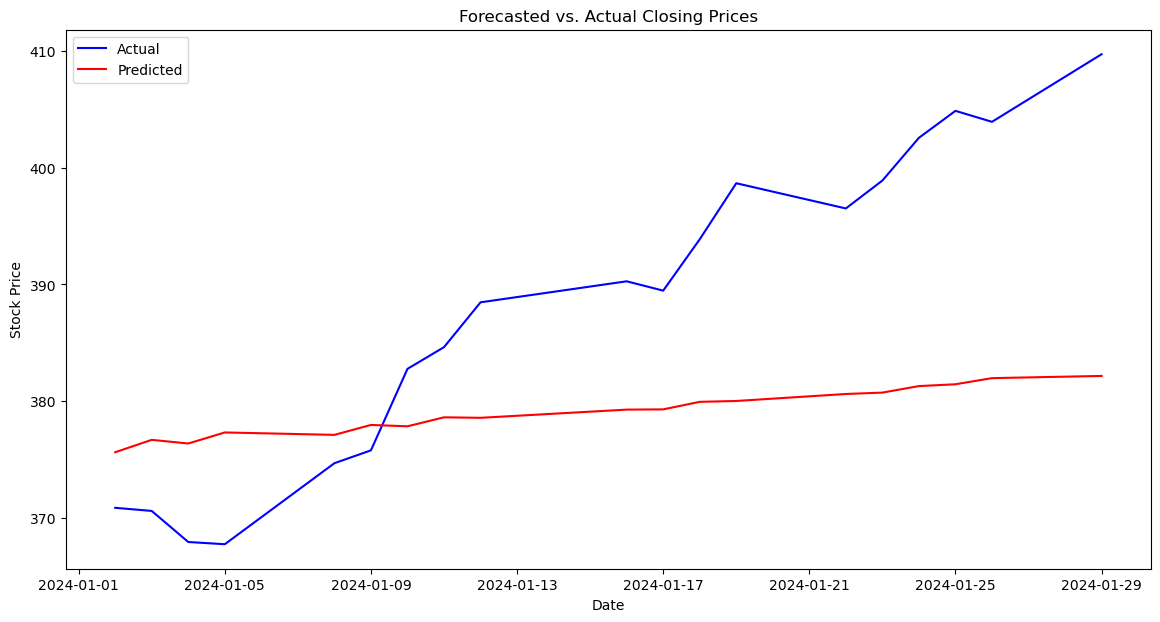

In [17]:
plt.figure(figsize=(14,7))
plt.plot(test.index,test.Close,color='blue',label='Actual')
plt.plot(test.index,actualforecast,color='red',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Forecasted vs. Actual Closing Prices')
plt.legend()
plt.show()

## END